**Name:**  Leung Wilson

**EID:**  wilsleung3


# CS4486 - Course Project: Stock Price Prediction

## Goal
In this project, you will be expected to use either genetic algorithms or regression machine learning algorithms like Ridge Regression, Recurrent Neural Network, and reinforcement learning algorithms to predict the price of a stock in the future.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.




# Load the Data

In [ ]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time
import os
from keras.layers.core import Dense, Activation, Dropout

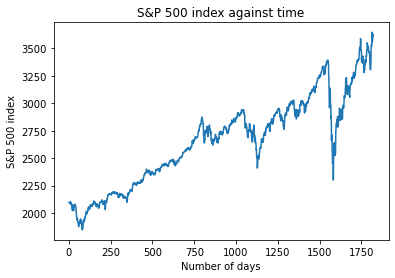

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

rdataframe = read_csv('yahoo_stock.csv', engine='python', skipfooter=3)
dataframe = read_csv('yahoo_stock.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# NORMALISE THE DATA
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.title('S&P 500 index against time')
plt.ylabel('S&P 500 index')
plt.xlabel('Number of days')
plt.plot(scaler.inverse_transform(dataset))

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



In [ ]:
print(len(trainX))
print(len(testX))

1218
600


In [ ]:
print(rdataframe.Close)

0       2086.590088
1       2089.139893
2       2088.870117
3       2088.870117
4       2090.110107
           ...     
1817    3585.149902
1818    3585.149902
1819    3585.149902
1820    3626.909912
1821    3609.530029
Name: Close, Length: 1822, dtype: float64


#  Building and Training a LSTM Model
A LSTM is built with some callbacks that can help to improve the model.

In [ ]:
layer_units=[50,100]
dropouts=[0.2,0.2]
window_size=1
model = Sequential()

# hidden layer 1
model.add(LSTM(layer_units[0],
                input_shape=(trainX.shape[1],1),
                return_sequences=True))
model.add(Dropout(dropouts[0]))

# hidden layer 2
model.add(LSTM(layer_units[1]))
model.add(Dropout(dropouts[1]))

# output layer
model.add(Dense(1))
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="adam") #optimizer="adam"
print("> Compilation Time : ", time.time() - start)
print(model.summary())


> Compilation Time :  0.0062830448150634766
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
________

In [ ]:
import keras
from sklearn.metrics import mean_squared_error



callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
model.fit(trainX, trainY, epochs=20, batch_size=32,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/20
37/37 [==============================] - 1s 29ms/step - loss: 0.0618 - val_loss: 0.0165
Epoch 2/20
37/37 [==============================] - 0s 11ms/step - loss: 0.0123 - val_loss: 0.0133
Epoch 3/20
37/37 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 4/20
37/37 [==============================] - 0s 10ms/step - loss: 0.0037 - val_loss: 0.0010
Epoch 5/20
37/37 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 1.8508e-04
Epoch 6/20
37/37 [==============================] - 0s 9ms/step - loss: 0.0010 - val_loss: 1.0263e-04
Epoch 7/20
37/37 [==============================] - 0s 10ms/step - loss: 9.4475e-04 - val_loss: 1.5335e-04
Epoch 8/20
37/37 [==============================] - 0s 9ms/step - loss: 9.3633e-04 - val_loss: 8.4701e-05
Epoch 9/20
37/37 [==============================] - 0s 8ms/step - loss: 9.1035e-04 - val_loss: 1.7179e-04
Epoch 10/20
37/37 [==============================] - 0s 8ms/step - loss: 8.5328e-

# 3. Preliminary Results

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 20.99 RMSE
Test Score: 63.28 RMSE


In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

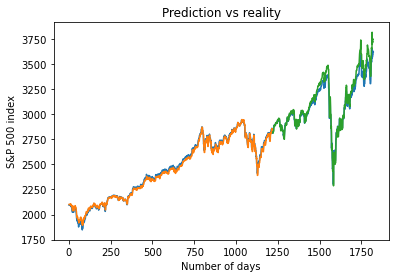

In [ ]:
plt.title('Prediction vs reality')
plt.ylabel('S&P 500 index')
plt.xlabel('Number of days')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 4. Further Adjustment
## Adding on more layer to the model
This time, we try to design a two hidden layer model, and see if there is any improvement.

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

rdataframe = read_csv('yahoo_stock.csv', engine='python', skipfooter=3)
dataframe = read_csv('yahoo_stock.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# NORMALISE THE DATA
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
#plt.plot(scaler.inverse_transform(dataset))

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))



In [ ]:
layer_units=[50,100,100]
dropouts=[0.2,0.2,0.2]
window_size=1
model = Sequential()

# hidden layer 1
model.add(LSTM(layer_units[0],
                input_shape=(trainX.shape[1],1),
                return_sequences=True))
model.add(Dropout(dropouts[0]))

model.add(LSTM(layer_units[1],return_sequences=True))
model.add(Dropout(dropouts[1]))

# hidden layer 2
model.add(LSTM(layer_units[2],return_sequences=True))
model.add(Dropout(dropouts[2]))

# output layer
model.add(Dense(1))
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="adam") #optimizer="adam"
print("> Compilation Time : ", time.time() - start)
print(model.summary())

> Compilation Time :  0.005426168441772461
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 100)            60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 100)            0         
_________________________________________________________________
dense_1 (De

In [ ]:

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=2,
                                           verbose=0)]
model.fit(trainX, trainY,
               epochs=20, batch_size=16,
               verbose=1,validation_split=0.05,
               callbacks=callbacks)
print("Model Fit Complete")

Epoch 1/20
73/73 [==============================] - 2s 26ms/step - loss: 0.0400 - val_loss: 0.0102
Epoch 2/20
73/73 [==============================] - 1s 13ms/step - loss: 0.0048 - val_loss: 1.5258e-04
Epoch 3/20
73/73 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 1.1406e-04
Epoch 4/20
73/73 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 9.7945e-05
Epoch 5/20
73/73 [==============================] - 1s 11ms/step - loss: 0.0010 - val_loss: 8.1817e-05
Epoch 6/20
73/73 [==============================] - 1s 10ms/step - loss: 9.9749e-04 - val_loss: 2.3053e-04
Epoch 7/20
73/73 [==============================] - 1s 9ms/step - loss: 8.5120e-04 - val_loss: 9.9563e-05
Model Fit Complete


In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [ ]:
nsamples, nx, ny = trainPredict.shape
trainPredict = trainPredict.reshape((nsamples,nx*ny))

nsamples, nx, ny = testPredict.shape
testPredict = testPredict.reshape((nsamples,nx*ny))

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 16.77 RMSE
Test Score: 41.03 RMSE


In [ ]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [ ]:
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

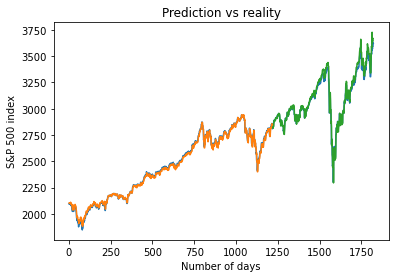

In [ ]:
plt.title('Prediction vs reality')
plt.ylabel('S&P 500 index')
plt.xlabel('Number of days')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# 5. Conclusion and Discussion
After adding the layer to the model, the RMSE of predicted results has decrease.

In the future, we may preprocess the dataset by using other model(such as Ridge Regression) to learn rather than LSTM.
Also, we may try change the look back days to achieve better results.